<a href="https://colab.research.google.com/github/vedantdave77/project.Orca/blob/master/MNIST_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Network

In this notebook, I will be building a generative adversarial network (GAN) trained on the MNIST dataset. From this, we'll be able to generate new handwritten digits!

The idea behind GANs is that you have two networks, a generator  𝐺  and a discriminator  𝐷 , competing against each other. The generator makes "fake" data to pass to the discriminator. The discriminator also sees real training data and predicts if the data it's received is real or fake.

>- The generator is trained to fool the discriminator, it wants to output data that looks as close as possible to real, training data.
>- The discriminator is a classifier that is trained to figure out which data is real and which is fake.

## Import Libraries 



In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

## Data Preparation

In [2]:
# import dataset from torch internal library
from torchvision import datasets
import torchvision.transforms as transforms

# define trainig paramters
num_workers = 2
batch_size = 64

transform = transforms.ToTensor()                                               # convert to tensor form
train_data = datasets.MNIST(root='data',train = True,download =True,transform=transform)
train_loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=False,num_workers=num_workers)

## Data visualization

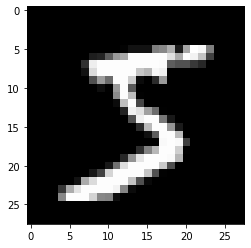

In [3]:
# retriving data from dataloader
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

img = np.squeeze(images[0])

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.imshow(img,cmap='gray')

## Train GAN Model 

A GAN is comprised of two adversarial networks, a discriminator and a generator.





### Discriminator
The discriminator network is going to be a pretty typical linear classifier. To make this network a universal function approximator, need at least one hidden layer, and these hidden layers should have one key attribute. And, hidden layer need leakyRelu function. Its same for the positive output. But, on the negative part it also contains value in small negative forms. so, we do not need to worry about information loss. At last we need answer in probability, and for that I will use sigmoid function.

Here, I will use BCEwithLOGITLoss function. Its special purpose function which have sigmoid function at the end of BCE loss function.

In [4]:
# generate discriminator

import torch.nn as nn
import torch.nn.functional as F

class Descriminator(nn.Module):
  def __init__(self, input_size, hidden_dim, output_size):
    super(Descriminator,self).__init__()

    # define hidden dimension layers
    self.fc1 = nn.Linear(input_size,hidden_dim*4)
    self.fc2 = nn.Linear(hidden_dim*4,hidden_dim*2)
    self.fc3 = nn.Linear(hidden_dim*2,hidden_dim)

    # fully connected layers
    self.fc4 = nn.Linear(hidden_dim,output_size)

    # dropout layer
    self.dropout = nn.Dropout(0.3)

# generate feed-forward network
  def forward(self,x):
    x = x.view(-1, 28*28)
    x = F.leaky_relu(self.fc1(x),0.2)                                           # 0.2 is slope value (negative)
    x = self.dropout(x)
    x = F.leaky_relu(self.fc2(x),0.2)
    x = self.dropout(x)
    x = F.leaky_relu(self.fc3(x),0.2)
    x = self.dropout(x)
    out = self.fc4(x)
    return out


### Generator

The generator network will be almost exactly the same as the discriminator network, except that we're applying a tanh activation function to our output layer.

>**tanh Output**

>- The generator has been found to perform the best with  𝑡𝑎𝑛ℎ  for the generator output, which scales the output to be between -1 and 1, instead of 0 and 1.

Due to this, we need to normalize our impurt images between -1 to 1. And, during dataloader we already normalize it between 0 to 1. 

In [5]:
# define generator 
class Generator(nn.Module):
  def __init__(self, input_size, hidden_dim, output_size):
    super(Generator,self).__init__()

    # define hidden dimension layers
    self.fc1 = nn.Linear(input_size,hidden_dim)
    self.fc2 = nn.Linear(hidden_dim,hidden_dim*2)
    self.fc3 = nn.Linear(hidden_dim*2,hidden_dim*4)

    # fully connected layers
    self.fc4 = nn.Linear(hidden_dim*4,output_size)

    # dropout layer
    self.dropout = nn.Dropout(0.3)

# generate feed-forward network
  def forward(self,x):
    x = F.leaky_relu(self.fc1(x),0.2)                                           # 0.2 is slope value
    x = self.dropout(x)
    x = F.leaky_relu(self.fc2(x),0.2)
    x = self.dropout(x)
    x = F.leaky_relu(self.fc3(x),0.2)
    x = self.dropout(x)
    out = F.tanh(self.fc4(x))                                                   # tanh is important
    return out


## Model **hyperparameters**

In [6]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 784                             
# Size of discriminator output (real or fake)
d_output_size = 1
# Size of last hidden layer in the discriminator
d_hidden_size = 32

# Generator hyperparams

# Size of latent vector  to give to generator
z_size = 100
# Size of discriminator output (generated image == same as input, and this will give to discriminator as input)
g_output_size = 784               
# Size of first hidden layer in the generator
g_hidden_size = 32

In [7]:
# So, Our Networks are:

D = Descriminator(input_size,d_hidden_size,d_output_size)
G = Generator(z_size,g_hidden_size,g_output_size)

print(G)
print()
print(D)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Descriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


## Calculate Losses 



### Descriminator Losses 

GAN always improve results with losses. Genertor and Descriminator has their own losses. Generator takes loss prediction from Desriminator. But,Desriminator need to measure losses by comparing generator output with real image dataset. Precision of descrimination gives better GAN result.

Desriminator has two different type of losses.
> - [1] Real Loss (positive output (1))
> - [2] Fake losses (negative output (0))

I will use **BCE with LOGIT LOSS**. Please visit pytorch documentation for that. 

In [8]:
# calculate losses

def real_loss(D_out,smooth=False):
  batch_size = D_out.size(0)
  if smooth:
    labels = torch.ones(batch_size)*0.9
  else:
    labels = torch.ones(batch_size)

  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(D_out.squeeze(),labels)
  return loss

def fake_loss(D_out):
  batch_size = D_out.size(0)
  labels = torch.zeros(batch_size)
  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(D_out.squeeze(),labels)
  return loss

## Optimizer 
I want to update the generator and discriminator variables separately. So, we'll define two separate Adam optimizers.

In [9]:
import torch.optim as optim

lr = 0.002

d_optimizer = optim.Adam(D.parameters(),lr)
g_optimizer = optim.Adam(G.parameters(),lr)


## GAN Training
Training will involve alternating between training the discriminator and the generator. We'll use our functions real_loss and fake_loss to help us calculate the discriminator losses in all of the following cases.

### Discriminator training
1. Compute the discriminator loss on real, training images        
2. Generate fake images
3. Compute the discriminator loss on fake, generated images     
4. Add up real and fake loss
5. Perform backpropagation + an optimization step to update the discriminator's weights

### Generator training
1. Generate fake images
2. Compute the discriminator loss on fake images, using **flipped** labels!
3. Perform backpropagation + an optimization step to update the generator's weights

#### Saving Samples

As we train, we'll also print out some loss statistics and save some generated "fake" samples.

In [10]:
import pickle as pkl  

num_epochs = 100

samples =[]
losses = []

print_every = 500
sample_size =16
fixed_z = np.random.uniform(-1,1, size = (sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

# train network 
D.train()
G.train()

for epoch in range(num_epochs):
  for batch_i, (real_images,_) in enumerate(train_loader):
    batch_size = real_images.size(0)
    # rescalling images (from (0to1) to (-1to1))
    real_images = real_images*2 -1

    # TRAIN DESCRIMINATOR
    d_optimizer.zero_grad()                                                     # What?
    D_real = D(real_images)
    d_real_loss =real_loss(D_real,smooth=True)

    z = np.random.uniform(-1,1,size=(batch_size,z_size))
    z = torch.from_numpy(z).float()
    fake_images = G(z)

    D_fake = D(fake_images)
    d_fake_loss = fake_loss(D_fake)

    # Total loss
    d_loss = d_real_loss + d_fake_loss
    d_loss.backward()
    d_optimizer.step()

    # TRAIN GENERATOR
    #=================
    g_optimizer.zero_grad()

    z = np.random.uniform(-1,1,size=(batch_size,z_size))
    z = torch.from_numpy(z).float()
    fake_images = G(z)

    D_fake = D(fake_images)
    g_loss = real_loss(D_fake)
    g_loss.backward()
    g_optimizer.step()

    # print stats
    if batch_i%print_every == 0:
      print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))
       
  # After each epoch 
  losses.append((d_loss.item(),g_loss.item()))

  # generate and save samples,fake images
  G.eval()
  sample_z = G(fixed_z)
  samples.append(sample_z)
  G.train()

with open('train_sample.pkl','wb') as f:
  pkl.dump(samples,f)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch [    1/  100] | d_loss: 1.4169 | g_loss: 0.6749
Epoch [    1/  100] | d_loss: 0.5951 | g_loss: 5.4586
Epoch [    2/  100] | d_loss: 1.1901 | g_loss: 1.7305
Epoch [    2/  100] | d_loss: 0.6794 | g_loss: 3.0169
Epoch [    3/  100] | d_loss: 0.8746 | g_loss: 3.2077
Epoch [    3/  100] | d_loss: 0.9343 | g_loss: 2.1407
Epoch [    4/  100] | d_loss: 1.2324 | g_loss: 1.0909
Epoch [    4/  100] | d_loss: 1.1076 | g_loss: 1.2703
Epoch [    5/  100] | d_loss: 1.1040 | g_loss: 1.1461
Epoch [    5/  100] | d_loss: 1.3758 | g_loss: 1.3351
Epoch [    6/  100] | d_loss: 1.2053 | g_loss: 1.2267
Epoch [    6/  100] | d_loss: 1.0901 | g_loss: 1.9063
Epoch [    7/  100] | d_loss: 1.1418 | g_loss: 2.1383
Epoch [    7/  100] | d_loss: 1.1037 | g_loss: 2.0848
Epoch [    8/  100] | d_loss: 1.0810 | g_loss: 2.1207
Epoch [    8/  100] | d_loss: 1.0816 | g_loss: 1.2939
Epoch [    9/  100] | d_loss: 1.2768 | g_loss: 1.2654
Epoch [    9/  100] | d_loss: 1.3058 | g_loss: 1.2779
Epoch [   10/  100] | d_loss

## Training Loss:


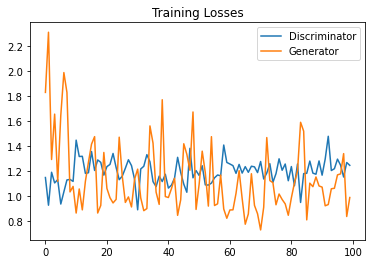

In [11]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

## Generator Samples from training

In [12]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [13]:
# Load samples from generator, taken while training
with open('train_sample.pkl', 'rb') as f:
    samples = pkl.load(f)

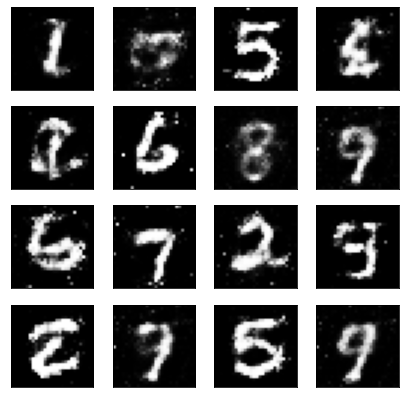

In [14]:
# -1 indicates final epoch's samples (the last in the list)
view_samples(-1, samples)

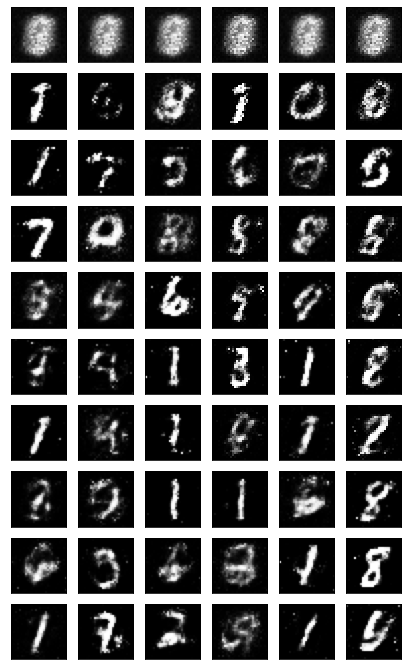

In [15]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

It starts out as all noise. Then it learns to make only the center white and the rest black. You can start to see some number like structures appear out of the noise like 1s and 9s.

# Sampling from generator
We can also get completely new images from the generator by using the checkpoint we saved after training. We just need to pass in a new latent vector  𝑧  and we'll get new samples!

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


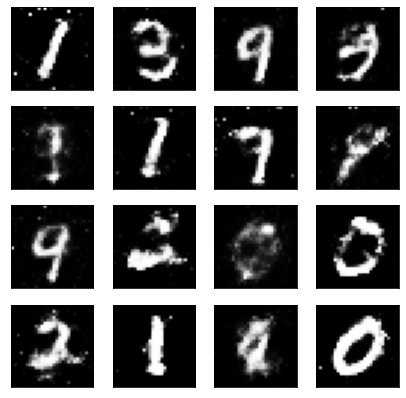

In [16]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1614: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


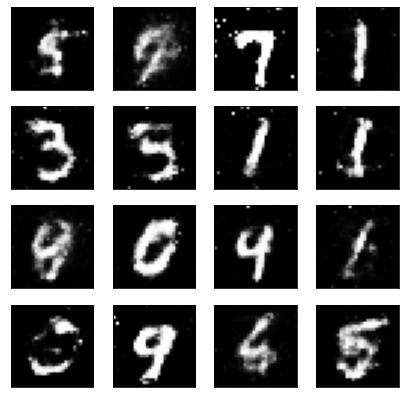

In [17]:
# randomly generated, new latent vectors
sample_size=16
rand_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
rand_z = torch.from_numpy(rand_z).float()

G.eval() # eval mode
# generated samples
rand_images = G(rand_z)

# 0 indicates the first set of samples in the passed in list
# and we only have one batch of samples, here
view_samples(0, [rand_images])

## Analysis:

Here, the last stage represents new hand written digits. Its generated by generator ownself. Still, Model needs improvement. 
